# A rotating mesh with pulsations

In [1]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_pulsation, evaluate_pulsations
from spice.plots import plot_3D_mesh_and_spectrum
from spice.spectrum import simulate_observed_flux
import astropy.units as u
import jax
import jax.numpy as jnp
import numpy as np
from transformer_payne import Blackbody
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
%matplotlib inline

from jax import config
config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", False)

PHOEBE: passband "Johnson:V" has a newer version available.  Run phoebe.list_passband_online_history("Johnson:V") to get a list of available changes and phoebe.update_passband("Johnson:V") or phoebe.update_all_passbands() to update.


Let's use the simplest example for the sake of speed - the blackbody flux from the ```transformer_payne``` package.

In [2]:
bb = Blackbody()

The API is in the functional paradigm - you pass a "model" mesh, and the function returns a modified version of the mesh. However, the original passed mesh still remains if you choose not to overwrite these variables.

$A = D + \sum_{n=1}^N cos(\frac{n}{P}t_n-\phi_n)$

In [3]:
import pickle

with open('../src/spice/icosphere_cache/icosphere_5.pickle', 'rb') as f:
    m = pickle.load(f)
    print(len(m[3]))

20480


In [6]:
base_temp = 5700

m = IcosphereModel.construct(10000, 1., 1.,
                             bb.to_parameters(), bb.parameter_names)
print(len(m.centers))

m = add_pulsation(m, jnp.array([0, 0]), 1., jnp.array([[1e-1, 0.]]))

20480


/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:222: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


In [7]:
m.log_gs

Array([3.3312473, 3.3312473, 3.3312473, ..., 3.3313668, 3.3313668,
       3.3313673], dtype=float32)

In [8]:
m.radius

Array(1., dtype=float32, weak_type=True)

In [169]:
TIMESTAMPS = jnp.linspace(0., 2., 1000)

In [170]:
from spice.plots import plot_3D_sequence
mps = [evaluate_pulsations(m, t) for t in TIMESTAMPS]

In [171]:
start_radius = jnp.mean(m.radii)
mean_radii = [jnp.max(mp.radii) for mp in mps]

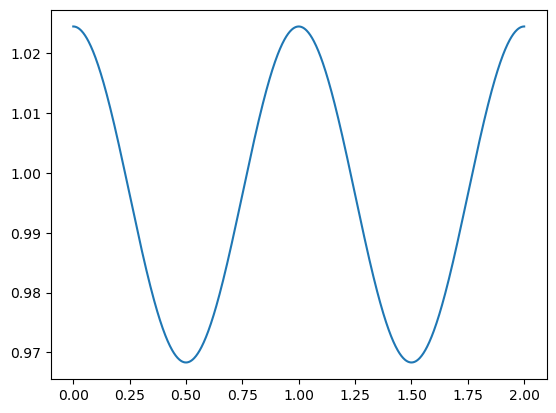

In [172]:
plt.plot(TIMESTAMPS, mean_radii)
plt.show()

In [173]:
start_area = jnp.sum(m.areas)
areas = [jnp.sum(mp.areas)/start_area for mp in mps]

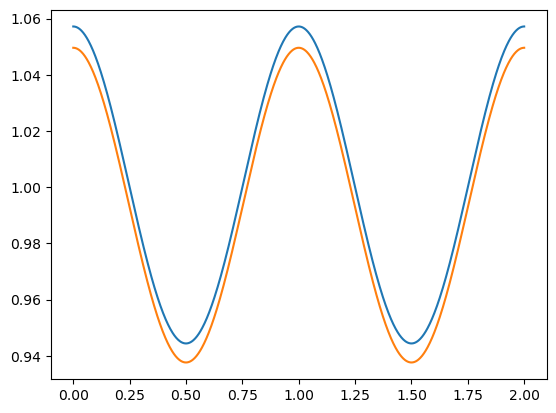

In [174]:
plt.plot(TIMESTAMPS, areas)
plt.plot(TIMESTAMPS, np.array(mean_radii)**2)

## Spectrum emulation

In [175]:
mps[0].mus.shape

(1280,)

In [176]:
bb

In [205]:
vws = jnp.linspace(100., 12000., 1000)
specs = [simulate_observed_flux(bb.intensity, mp0, jnp.log10(vws), disable_doppler_shift=False) for mp0 in tqdm(mps)]

100%|██████████| 1000/1000 [00:19<00:00, 51.65it/s]


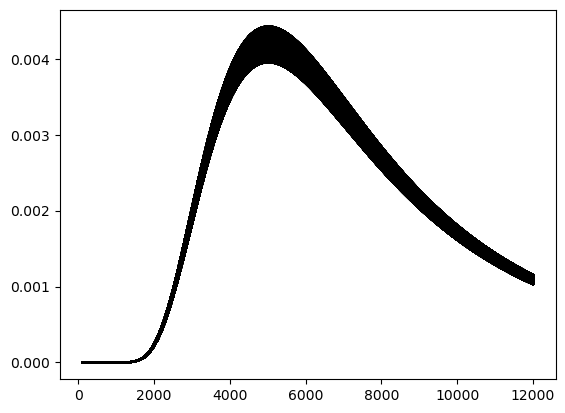

In [206]:
import matplotlib.pyplot as plt

for spec in specs:
    plt.plot(vws, spec, color='black', alpha=0.5)

In [236]:
mps[0].log_gs

Array([-16.551332, -16.551332, -16.551332, ..., -16.549574, -16.549574,
       -16.549454], dtype=float32)

In [207]:
len(specs)

1000

(<Figure size 2400x1000 with 3 Axes>,
 <Axes3D: xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$', zlabel='$Z [R_\\odot]$'>,
 <Axes: xlabel='wavelength [$\\AA$]', ylabel='intensity [erg/s/cm$^2$]'>)

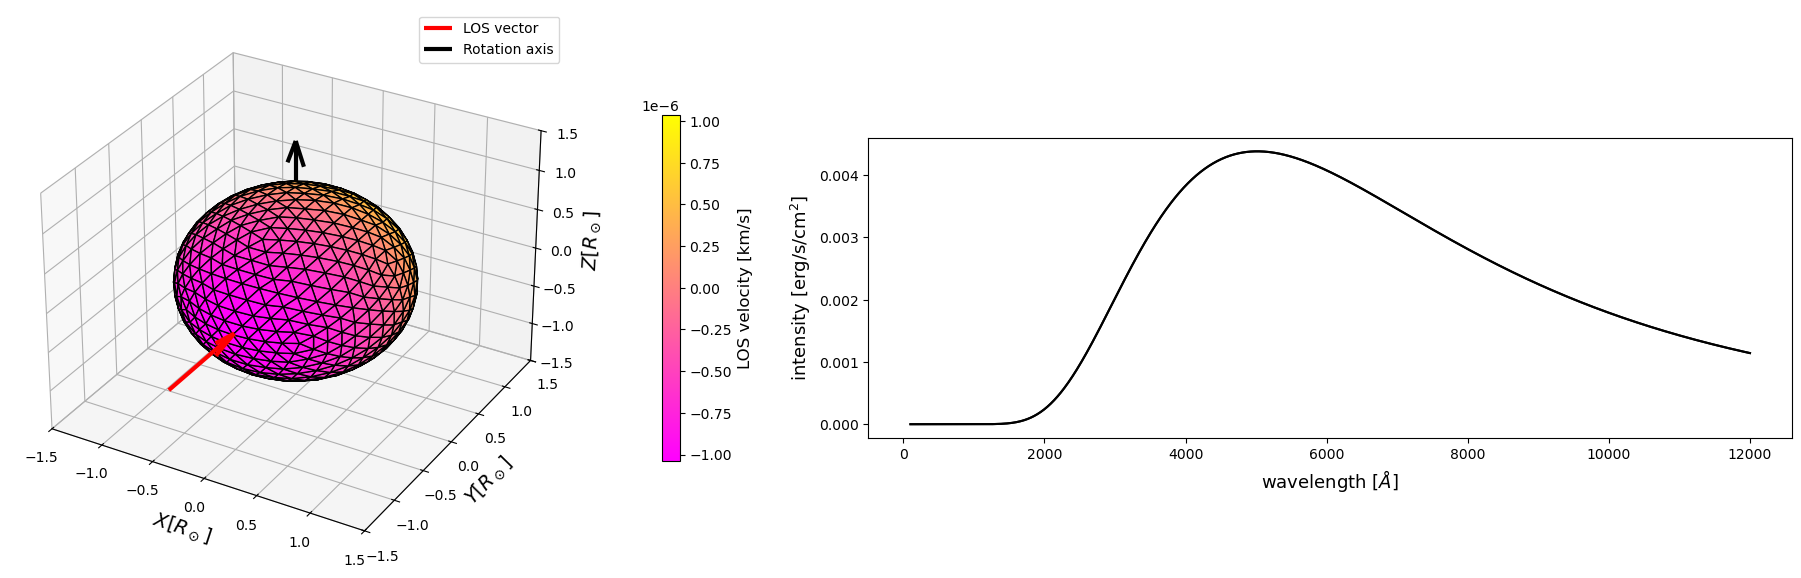

In [208]:
time_idx = 50
plot_3D_mesh_and_spectrum(mps[time_idx], vws, specs[time_idx], dict(property='los_velocities', cmap='spring'))

In [209]:
len(mps[::50])

20

In [210]:
# from spice.plots import animate_mesh_and_spectra
# 
# animate_mesh_and_spectra(mps[::50], TIMESTAMPS[::50], vws, specs[::50], 'pulsation.gif')

## Photometric time series

In [211]:
from spice.spectrum.filter import BesselU, BesselB, BesselV, Bolometric, GaiaG
from spice.spectrum.spectrum import AB_passband_luminosity

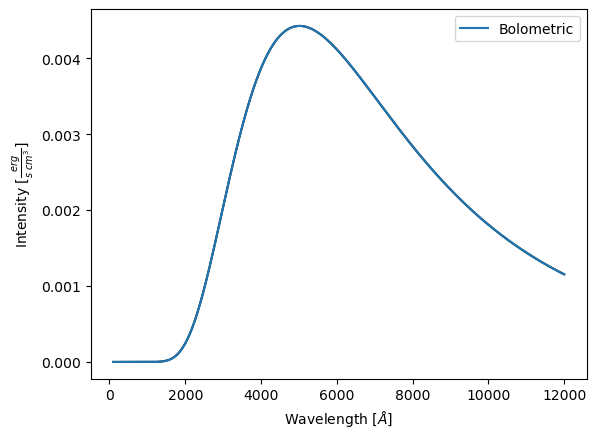

In [212]:
Bolometric().plot_filter_responses_for_wavelengths(vws, specs[0][:, 0])

In [213]:
bolometric = GaiaG()

In [214]:
d = u.AU.to(u.cm)
bolo = np.array([AB_passband_luminosity(bolometric, vws, flux[:, 0]) for flux in specs])

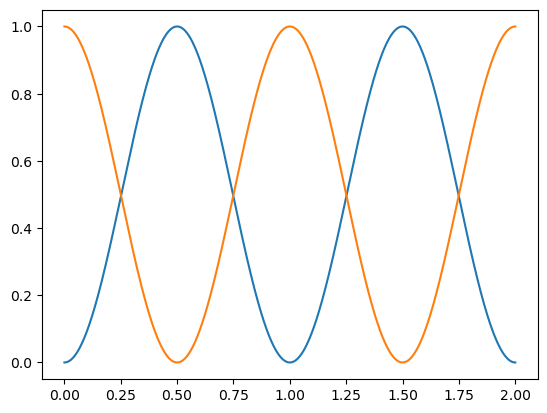

In [215]:
mean_radii = np.array(mean_radii)
plt.plot(TIMESTAMPS, (bolo - bolo.min()) / (bolo.max() - bolo.min()))
plt.plot(TIMESTAMPS, (mean_radii - mean_radii.min()) / (mean_radii.max() - mean_radii.min()))

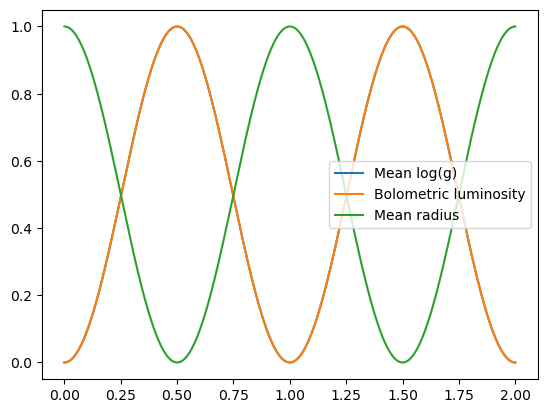

In [216]:
mean_loggs = np.array([jnp.mean(mp.log_gs) for mp in mps])
fig = plt.figure()
plt.plot(TIMESTAMPS, (mean_loggs-mean_loggs.min())/(mean_loggs.max()-mean_loggs.min()), label='Mean log(g)')
plt.plot(TIMESTAMPS, (bolo - bolo.min()) / (bolo.max() - bolo.min()), label='Bolometric luminosity')
plt.plot(TIMESTAMPS, (mean_radii - mean_radii.min()) / (mean_radii.max() - mean_radii.min()), label='Mean radius')
plt.legend()

In [217]:
fig.savefig('bolometric_pulsation.png')

In [218]:
from spice.spectrum.spectrum import luminosity

bls = [luminosity(bb.flux, mps1, vws) for mps1 in mps]

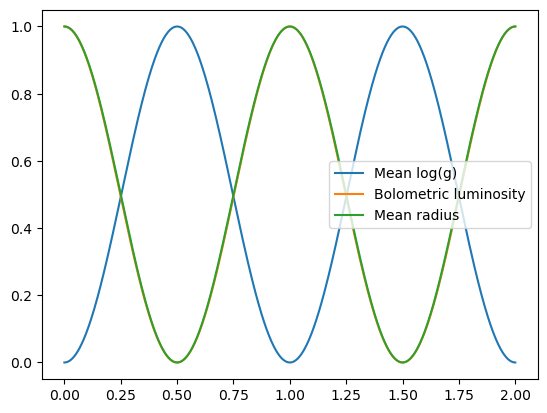

In [219]:
bls = np.array(bls)
fig = plt.figure()
plt.plot(TIMESTAMPS, (mean_loggs-mean_loggs.min())/(mean_loggs.max()-mean_loggs.min()), label='Mean log(g)')
plt.plot(TIMESTAMPS, (bls - bls.min()) / (bls.max() - bls.min()), label='Bolometric luminosity')
plt.plot(TIMESTAMPS, (mean_radii - mean_radii.min()) / (mean_radii.max() - mean_radii.min()), label='Mean radius')
plt.legend()

In [220]:
fig.savefig('total_luminosity_pulsation.png')

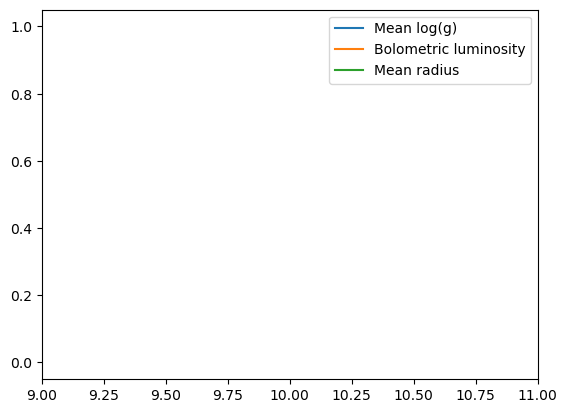

In [221]:
mean_loggs = np.array([jnp.mean(mp.log_gs) for mp in mps])
plt.plot(TIMESTAMPS, (mean_loggs-mean_loggs.min())/(mean_loggs.max()-mean_loggs.min()), label='Mean log(g)')
plt.plot(TIMESTAMPS, (bolo - bolo.min()) / (bolo.max() - bolo.min()), label='Bolometric luminosity')
plt.plot(TIMESTAMPS, (mean_radii - mean_radii.min()) / (mean_radii.max() - mean_radii.min()), label='Mean radius')
plt.gca().set_xlim(9, 11)
plt.legend()

In [222]:
plt.savefig('wierd.png')

<Figure size 640x480 with 0 Axes>

In [224]:
bessel_B = BesselB()
bessel_U = BesselU()
bessel_V = BesselV()

In [225]:
d = u.AU.to(u.cm)
U_phot = np.array([AB_passband_luminosity(bessel_U, vws, flux[:, 0]) for flux in specs])
B_phot = np.array([AB_passband_luminosity(bessel_B, vws, flux[:, 0]) for flux in specs])
V_phot = np.array([AB_passband_luminosity(bessel_V, vws, flux[:, 0]) for flux in specs])

# Calculate color indices
U_B = U_phot - B_phot
B_V = B_phot - V_phot


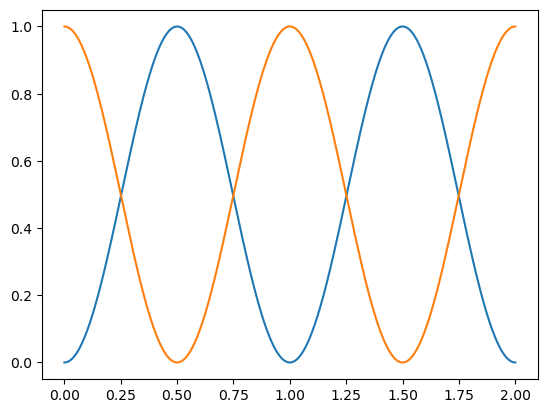

In [226]:
mean_radii = np.array(mean_radii)
plt.plot(TIMESTAMPS, (V_phot-V_phot.min())/(V_phot.max()-V_phot.min()))
plt.plot(TIMESTAMPS, (mean_radii-mean_radii.min())/(mean_radii.max()-mean_radii.min()))

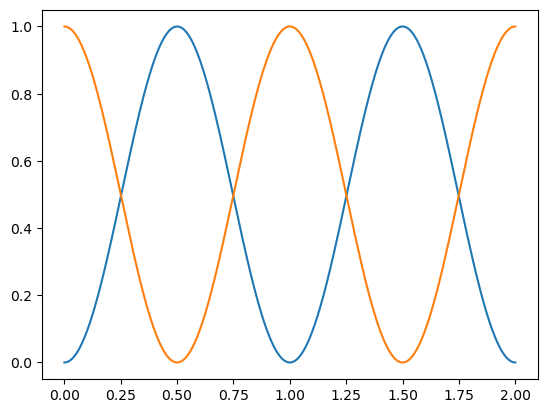

In [227]:
mean_radii = np.array(mean_radii)
plt.plot(TIMESTAMPS, (V_phot-V_phot.min())/(V_phot.max()-V_phot.min()))
plt.plot(TIMESTAMPS, (mean_radii-mean_radii.min())/(mean_radii.max()-mean_radii.min()))

(9.0, 11.0)

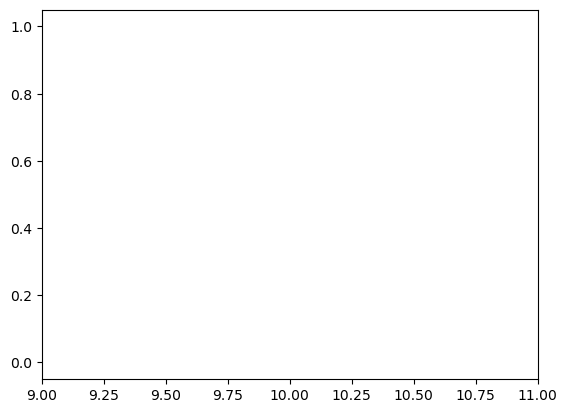

In [228]:
plt.plot(TIMESTAMPS, (V_phot-V_phot.min())/(V_phot.max()-V_phot.min()))
plt.plot(TIMESTAMPS, (mean_radii-mean_radii.min())/(mean_radii.max()-mean_radii.min()))
plt.gca().set_xlim(9, 11)

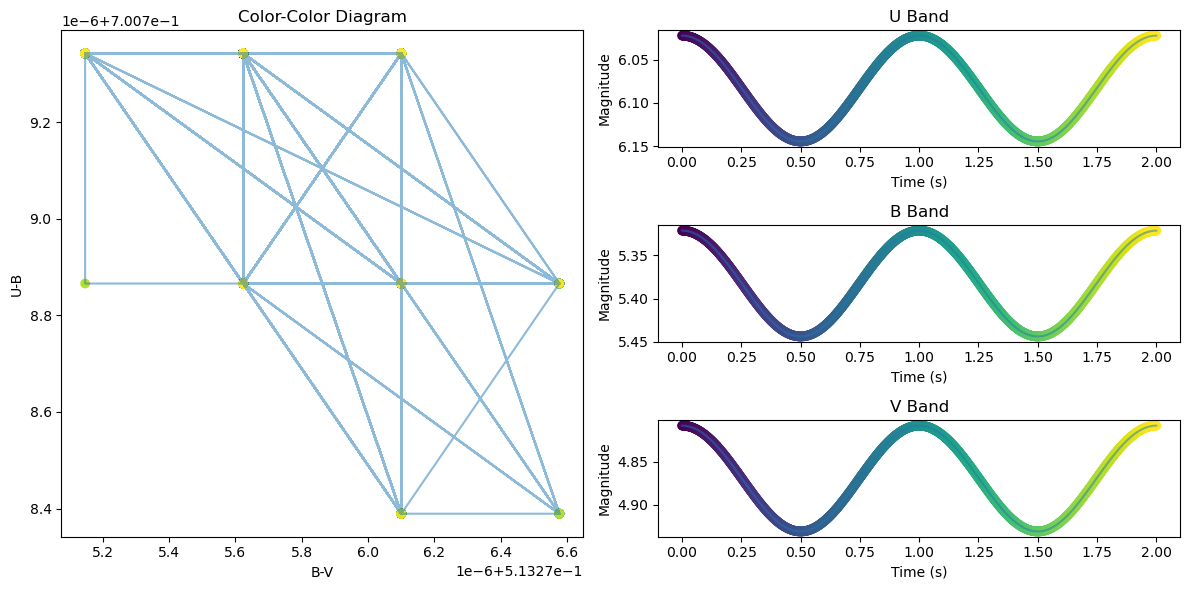

In [229]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Plot color-color diagram
ax_color = fig.add_subplot(gs[:, 0])
ax_color.plot(B_V, U_B, alpha=0.5)
ax_color.scatter(B_V, U_B, c=TIMESTAMPS, cmap='viridis')
ax_color.set_xlabel('B-V')
ax_color.set_ylabel('U-B')
ax_color.set_title('Color-Color Diagram')

# Photometry data and labels for loop
phot_data = [U_phot, B_phot, V_phot]
labels = ['U Band', 'B Band', 'V Band']

# Create photometry magnitude time series plots
for i, (data, label) in enumerate(zip(phot_data, labels)):
    ax = fig.add_subplot(gs[i, 1])
    ax.plot(TIMESTAMPS, data, label=label, alpha=0.5)
    ax.scatter(TIMESTAMPS, data, c=TIMESTAMPS, cmap='viridis', label='Markers')

    ax.set_title(label)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Magnitude')
    ax.invert_yaxis()

plt.tight_layout()

In [233]:
from astropy.timeseries import LombScargle
frequency = np.linspace(1/25, 2, 10000)
power = LombScargle(TIMESTAMPS[10:], U_phot[10:]).power(frequency)

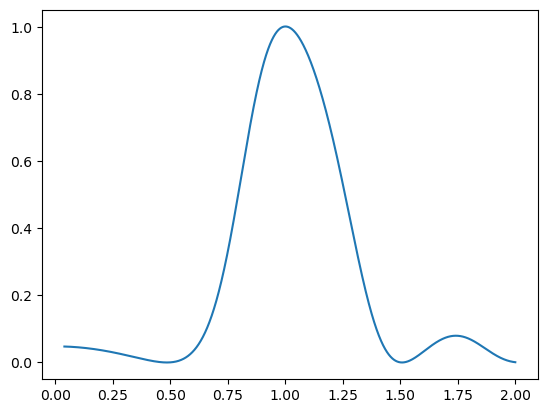

In [234]:
plt.plot(frequency, power)

In [235]:
1/frequency[np.argmax(power)]

0.9993084094216226